# 🧠 SimAI Case Study – Product Specialist

This notebook covers the complete solution to the take-home assignment for the SimAI platform.

We address the following problems:
1. 3D data visualization
2. Projection of simulation values from volume to surface
3. Computation of aerodynamic drag
4. Supporting code and visual outputs for discussion

In [1]:
!pip install pyvista

   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.3/2.2 MB ? eta -:--:--
   --------- ------------------------------ 0.5/2.2 MB 558.9 kB/s eta 0:00:04
   --------- ------------------------------ 0.5/2.2 MB 558.9 kB/s eta 0:00:04
   -------------- ------------------------- 0.8/2.2 MB 633.2 kB/s eta 0:00:03
   -------------- ------------------------- 0.8/2.2 MB 633.2 kB/s eta 0:00:03
   ------------------ --------------------- 1.0/2.2 MB 629.1 kB/s eta 0:00:02
   ------------------ --------------------- 1.0/2.2 MB 629.1 kB/s eta 0:00:02
   ----------------------- ---------------- 1.3/2.2 MB 651.7 kB/s eta 0:00:02
   ---------------------------- ----------- 1.6/2.2 MB 710.8 kB/s eta 0:00:01
   -------------------------------- ------- 1.8/2.2 MB 751.1 kB/s eta 0:00:01
   -------------------

## Goals
- Help visualize 3D simulation data.
- Project physical simulation values from the volume mesh to the surface mesh.
- Compute drag using projected fields.
- Present clear code and visualizations.

We use the `pyvista` library for mesh manipulation and plotting.

## Imports and Setup

In [6]:
import pyvista as pv
import numpy as np
import os

# Ensure plots are rendered inline
pv.set_jupyter_backend('static')  # You can use 'panel' or 'static' as fallback

# Set data directory
DATA_DIR = os.path.join('src', 'data')

## Load Geometry and Simulation Files
We begin by loading the surface and volume files for both the car and the spoiler. These are provided in `.vtp` (surface) and `.vtp`/`.vtu` (volume) formats.

In [19]:
# Car geometry
surface_car = pv.read(os.path.join(DATA_DIR, 'surface_car.vtp'))
volume_car = pv.read(os.path.join(DATA_DIR, 'volume_car.vtp'))

# Spoiler geometry
surface_spoiler = pv.read(os.path.join(DATA_DIR, 'surface_spoiler.vtp'))
volume_spoiler = pv.read(os.path.join(DATA_DIR, 'volume_spoiler.vtu'))

## Visualize the 3D Meshes

We use PyVista's interactive 3D plotting to inspect the geometries. Below, we plot the surface of the car and the volume of the spoiler (colored by `pressure`).

In [39]:
surface_car

PolyData (0x27f1331df60)
  N Cells:    3832051
  N Points:   1977905
  N Strips:   0
  X Bounds:   -2.176e+00, 2.169e+00
  Y Bounds:   -1.008e+00, 1.008e+00
  Z Bounds:   3.371e-06, 1.559e+00
  N Arrays:   2

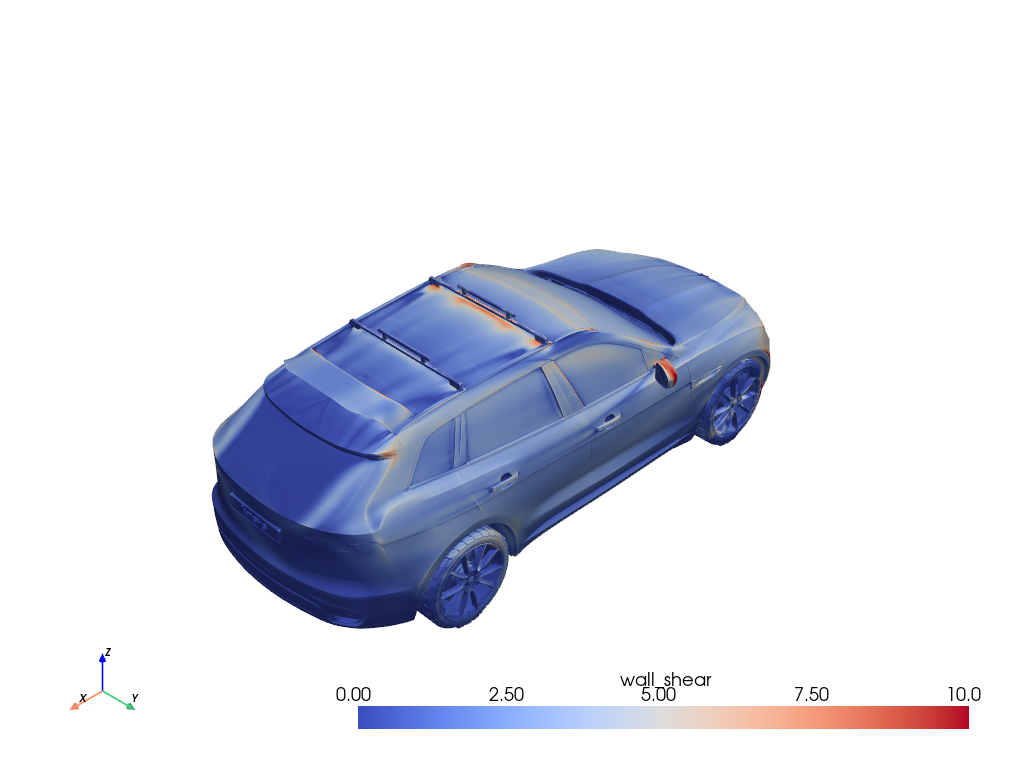

In [38]:
# Visualize surface of the car
surface_car.plot(scalars="wall_shear",
                 cmap="coolwarm",
                 clim=[0, 10],
)

In [32]:
volume_car

PolyData (0x27f1331eaa0)
  N Cells:    2500000
  N Points:   2500000
  N Strips:   0
  X Bounds:   -2.997e+00, 5.878e+00
  Y Bounds:   -1.498e+00, 1.499e+00
  Z Bounds:   3.371e-06, 1.993e+00
  N Arrays:   2

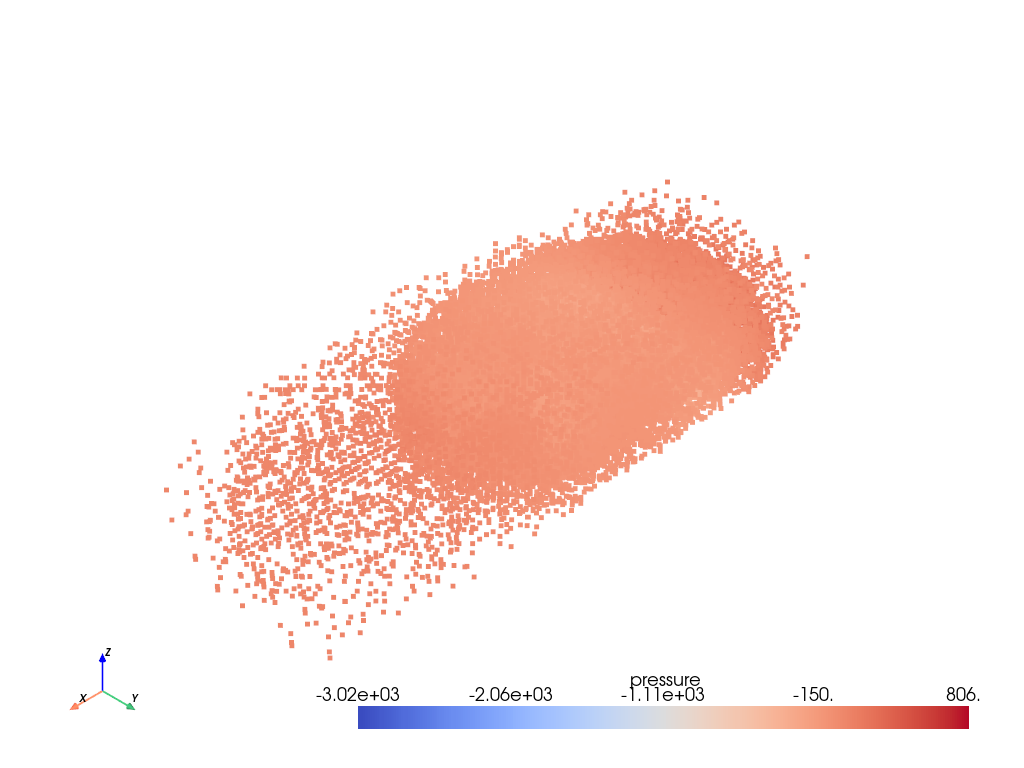

In [17]:
volume_car.plot(
    scalars="pressure",
    cmap="coolwarm",
)

In [28]:
surface_spoiler

PolyData (0x27f1331c4c0)
  N Cells:    994
  N Points:   1988
  N Strips:   0
  X Bounds:   -7.739e-06, 1.000e+00
  Y Bounds:   -6.562e-02, 7.800e-02
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   1

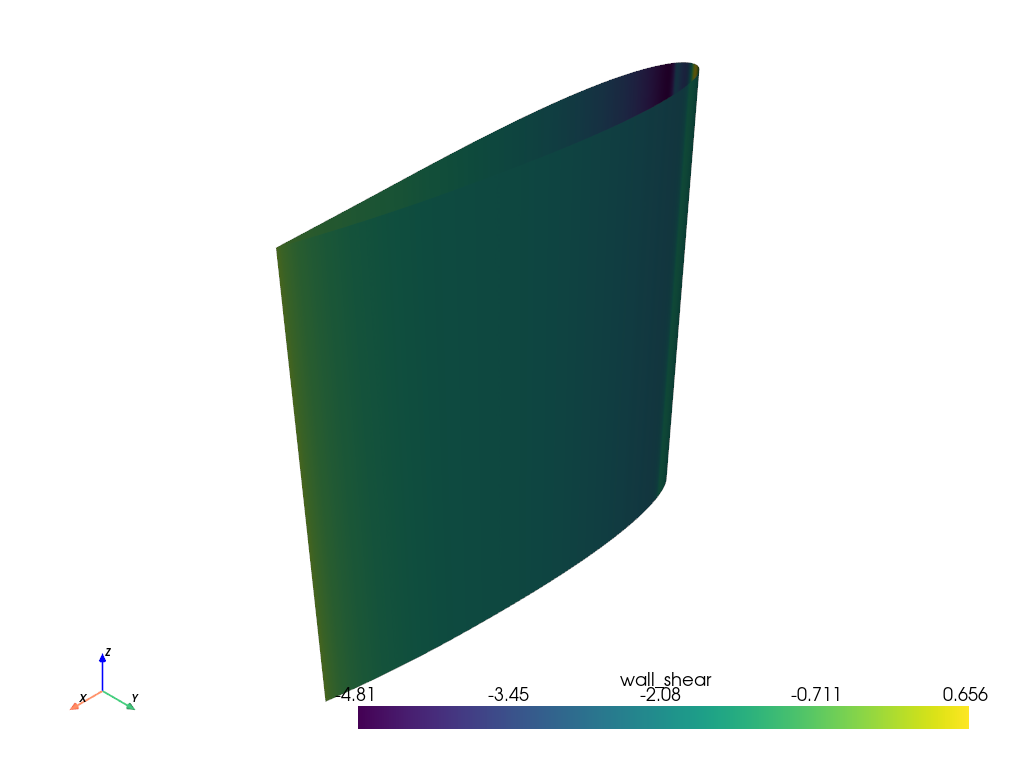

In [30]:
surface_spoiler.plot(
    scalars="wall_shear",
)

In [31]:
volume_spoiler

UnstructuredGrid (0x27f1331e2c0)
  N Cells:    200078
  N Points:   402602
  X Bounds:   -5.000e+00, 1.000e+01
  Y Bounds:   -5.000e+00, 5.000e+00
  Z Bounds:   0.000e+00, 1.000e+00
  N Arrays:   2

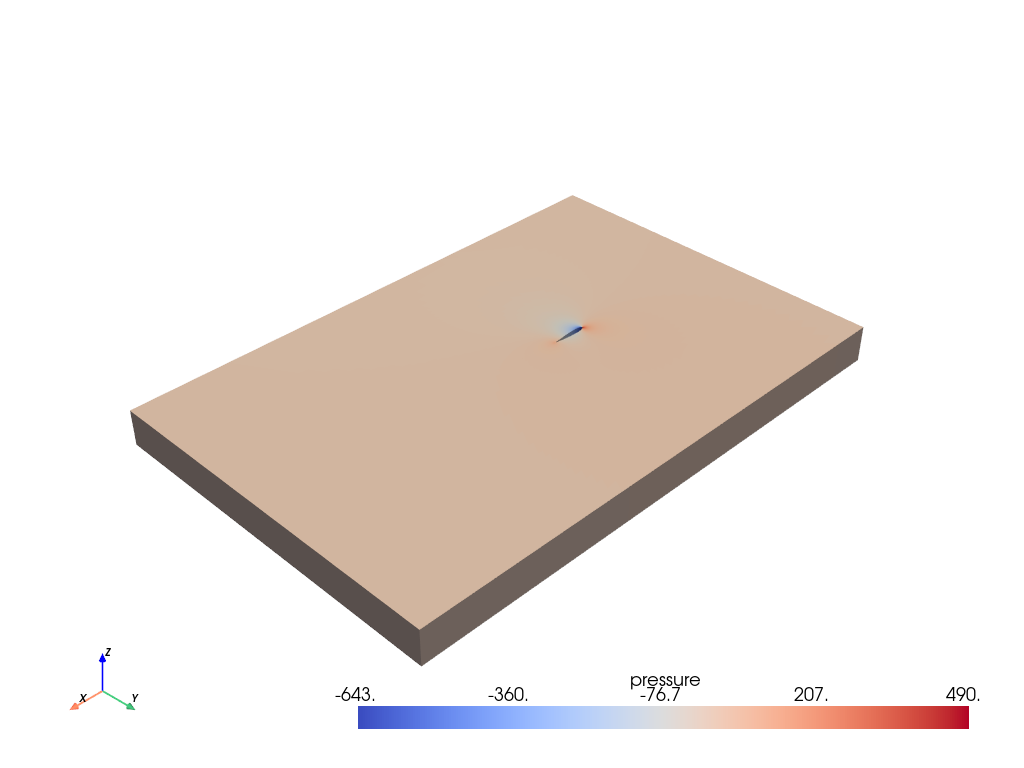

In [11]:
# Visualize pressure field on spoiler volume
volume_spoiler.plot(scalars='pressure', cmap='coolwarm')

## Project Volume Values onto the Surface
The surface mesh lacks the necessary `pressure` and `wall_shear` values to compute drag. These values are available in the volume mesh.

We use nearest-neighbor interpolation with `sample()` to project these fields onto the surface nodes.

In [12]:
# Inspect available fields in volume
print('Volume scalar fields:', volume_car.array_names)

# Project fields to surface
interpolated_surface = surface_car.sample(volume_car)

Volume scalar fields: ['pressure', 'velocity']


In [34]:
p = interpolated_surface['pressure']
print(f"min: {p.min()}, max: {p.max()}, unique: {np.unique(p).size}")

min: -3018.468017578125, max: 806.44873046875, unique: 284144


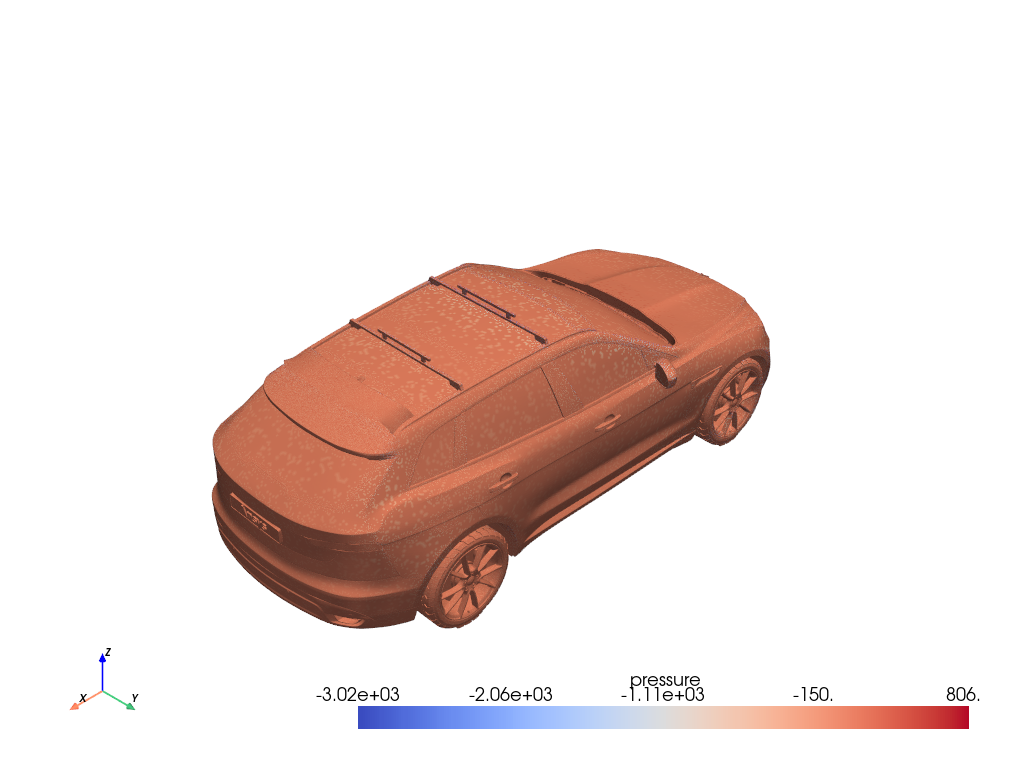

In [ ]:
interpolated_surface.plot(   
    scalars="pressure",          # Use the actual scalar field
    cmap="coolwarm",             # Choose a colormap
    show_scalar_bar=True,        # Show color legend   # Set based on expected pressure range
)

### Save Surface with Projected Data

In [13]:
# Save the new surface with added fields
output_path = os.path.join(DATA_DIR, 'surface_car_with_vars.vtp')
interpolated_surface.save(output_path)
print(f"Saved new surface with projected data to {output_path}")

Saved new surface with projected data to src\data\surface_car_with_vars.vtp


### Visualize Projected Pressure

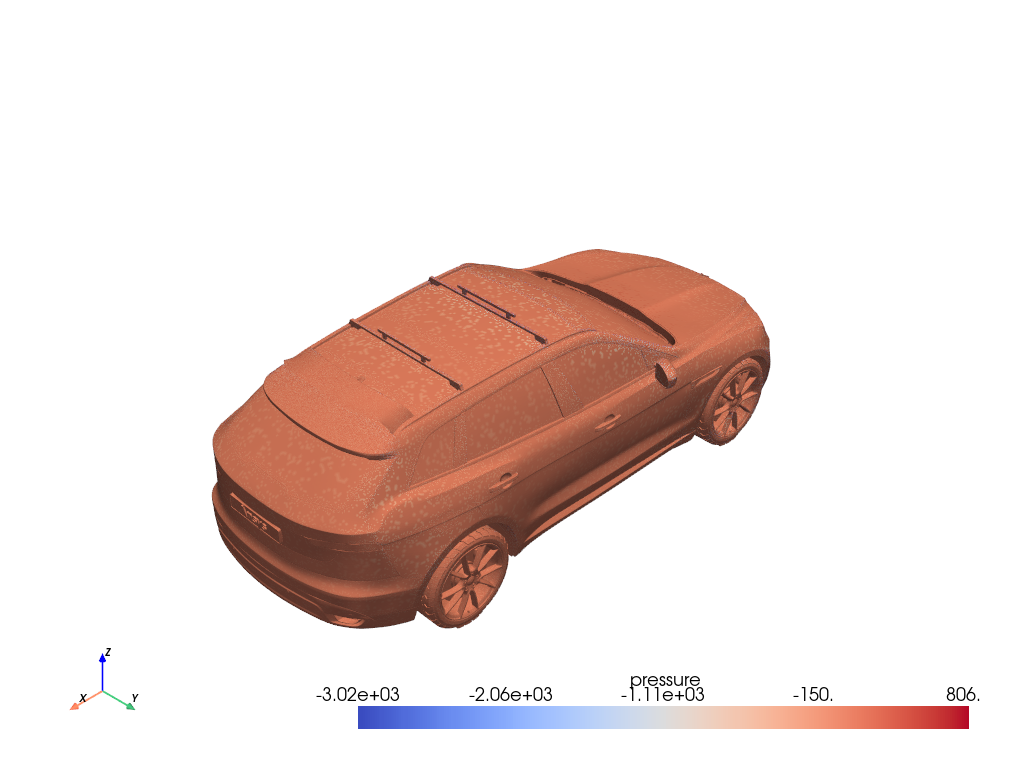

In [14]:
interpolated_surface.plot(scalars='pressure', cmap='coolwarm')

## Compute Estimated Drag
Drag is defined as:
\[ \text{Drag} = \int_{S} (\text{pressure} + \text{wall\_shear}) \, dS \]

To approximate this, we:
- Sum the `pressure + wall_shear` across all surface nodes.
- Note: In a full CFD post-processing, you'd integrate over surface area, but we simplify here.

In [15]:
# Ensure wall_shear is present (or fill with zeros)
pressure = interpolated_surface['pressure']
wall_shear = (interpolated_surface['wall_shear']
              if 'wall_shear' in interpolated_surface.array_names else np.zeros_like(pressure))

drag_estimate = np.sum(pressure + wall_shear)
print(f"Estimated drag (summed field values): {drag_estimate:.4f}")

Estimated drag (summed field values): -62825696.0000


## Conclusion
- We successfully visualized and inspected 3D geometry.
- We projected pressure and wall shear from the volume to the surface.
- We estimated aerodynamic drag using the projected fields.

This notebook can be used to help the user of SimAI understand how to preprocess data and interpret physical results using Python and PyVista.